**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Importing relevant packages
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"}) 
from scipy import optimize
import time

# Autoreload of our model 
%load_ext autoreload
%autoreload 2

import Question_1 as Q1

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**1.1.1** We are defining the functions in symbolic math

In [2]:
# Defining symbols
C = sm.symbols('C') 
G = sm.symbols('G')
L = sm.symbols('L')
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
tau = sm.symbols('tau')
#Using this to get a tilde over the w. 
sm.init_printing()
wtilde= sm.symbols("wtilde ")

# write out the consumer utility function
utility = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2

#Budget constraint
budget = sm.Eq(C, kappa+wtilde*L)


**1.1.2** Isolate and Substitute

In [3]:
#Isolate (necessary since sympy otherwise does not work)
C_from_con = sm.solve(budget, C)
C_from_con[0]

#Substitute into utility function
objective = utility.subs(C, C_from_con[0])
objective


**1.1.3** Finding FOC wrt. L

In [4]:
#Finding the FOC
foc = sm.Eq(sm.diff(objective, L),0)
foc

**1.1.4** Solving for L in the equation

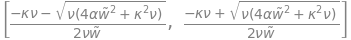

In [5]:
L_star = sm.solve(foc, L)
L_star

We note that $L^{\star}$ cannot be negative, so only the second solution holds. That is:

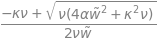

In [6]:
L_star[1]

We have shown the result now. $\nu$ can be simplified away (The square root can be rewritten, so we have $\nu^2$ and then we have a $\nu$ in all terms, and hereby it can be removed), and we get the following expression for the optimal labor supply:

$L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$

G is not important since we are taking the log. Hereby it will not influence in this case, as it is not dependent on $\tau$. However, this will of course change in exercise 1.3. 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

**1.2.1** Substitute w into the expression for $L^*$

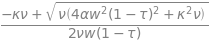

In [7]:
# Defining wtilde
wtilde_func=sm.Eq(wtilde,(1-tau)*w)
wtilde_from_con = sm.solve(wtilde_func, wtilde)
wtilde_from_con [0]

#Substitute into L_star
L_star_w = L_star[1].subs(wtilde, wtilde_from_con[0])
L_star_w

**1.2.2** Lambdify the function

In [8]:
#Create function
sol_L = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=L_star_w)

#Defining the baseline parameters
alpha_val=0.5
kappa_val=1.0
nu_val=(2.0*16.0**2.0)**(-1.0)
tau_val=0.3

#Create a grid for w. We don't start from 0, because then we get a division by zero error.
w_vec=np.linspace(0.1,5.0,100)

#Run sol_func
L_w=sol_L(kappa_val,nu_val,alpha_val,w_vec,tau_val)

**1.2.3** Plotting the results

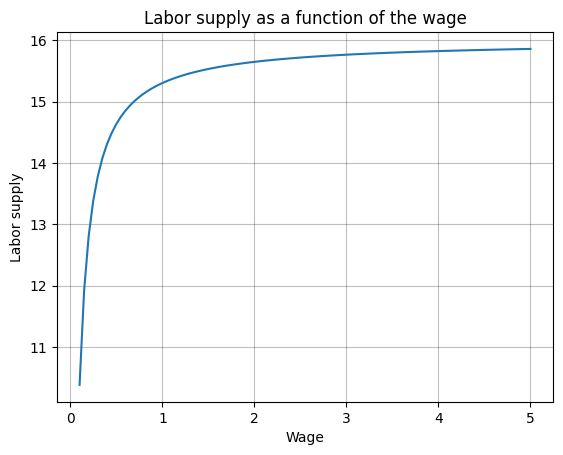

In [9]:
#Create the figure
fig = plt.figure()

#Add subplot
ax = fig.add_subplot(1,1,1)

#Plot labor supply as a function of the wage
ax.plot(w_vec,L_w)

#Add title and axis labels
ax.set_title('Labor supply as a function of the wage')
ax.set_xlabel('Wage')
ax.set_ylabel('Labor supply')

plt.show()

Here we see that labor supply is increasing in wage, but that the relationship is concave. This makes sense intuitively: If the worker receives a higher wage, then worker would like to work more, however the worker also receives relatively increasing disutility from working, so the effect wears off.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We would like to notice we use the optimal labor supply from question 1.2. The consequence is that the worker will not take the effect of more government spendings when working more. Ceteris parisbus, this will lower the labor supply. One argument is that the consumer does not feel able to affect the government spendings and therefore does not take it into account. 

**1.3.1** Define G and lambdify the function

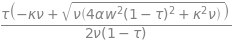

In [10]:
#Define G as a function of optimal L*:
G_new = tau*w*L_star_w
G_new

In [11]:
#Lambdify
sol_G = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=G_new)

**1.3.2** Define worker utility and lamdify

In [12]:
#Define utility as a function of optimal L* and G:
utility = sm.log((kappa+(1-tau)*w*L_star_w)**alpha*G_new**(1-alpha))-nu*L_star_w**2/2

In [13]:
#lambdify
sol_utility = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=utility)

**1.3.3** Define parameters

Now we're interested in the relationship between tau and L, G and utility respectively. Therefore wage we set to it's baseline value and we specify $\tau$ as a vector.

In [14]:
#Baseline w
w_val = 1.0

#Vector of tau. Cannot be 0 or 1.
tau_vec = np.linspace(0.05,0.95,100)

**1.3.4** Run functions

In [15]:
#labor supply
L_tau = sol_L(kappa_val,nu_val,alpha_val,w_val,tau_vec)

#government consumption
G_tau = sol_G(kappa_val,nu_val,alpha_val,w_val,tau_vec)

#utility
u_tau = sol_utility(kappa_val,nu_val,alpha_val,w_val,tau_vec)

**1.3.5** Plotting the results

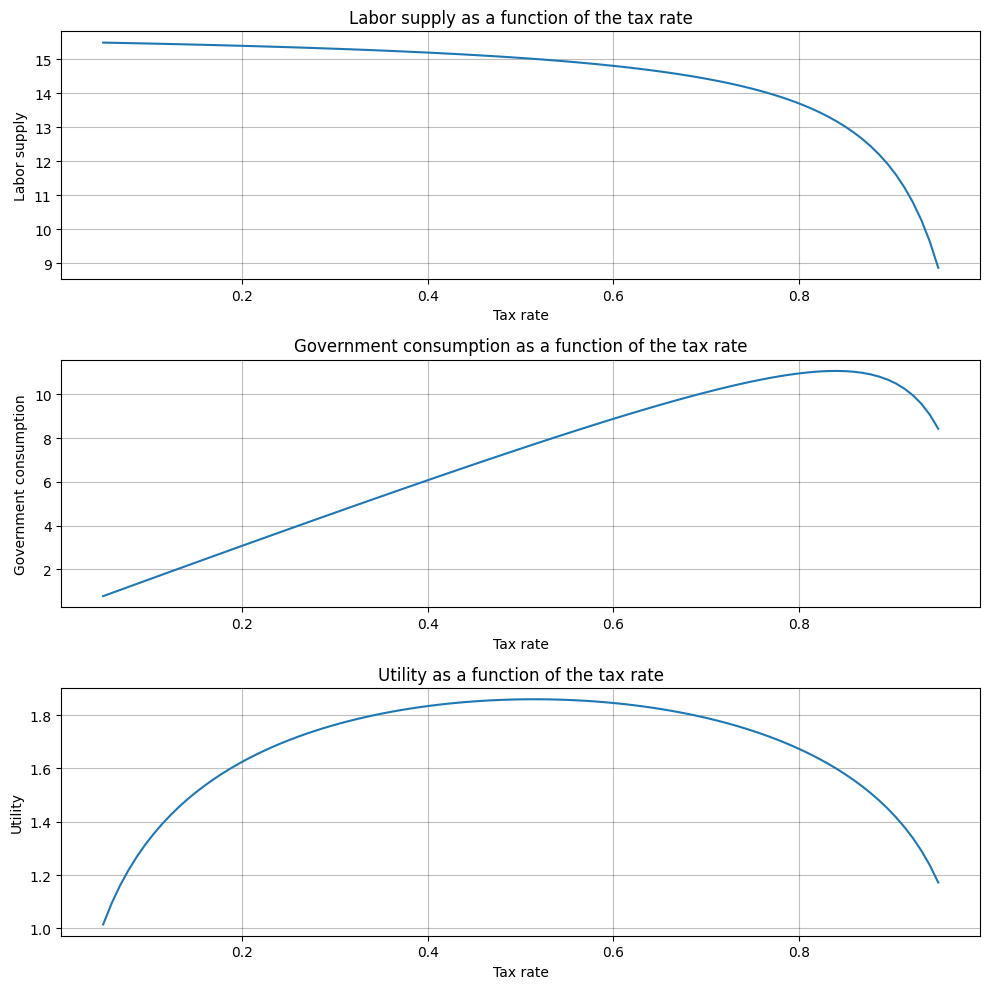

In [16]:
#Create the figure
fig = plt.figure(figsize=(10,10))

# a. Labor supply
ax = fig.add_subplot(3,1,1)
ax.plot(tau_vec,L_tau)
ax.set_title('Labor supply as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Labor supply')

#b. Government consumption
ax = fig.add_subplot(3,1,2)
ax.plot(tau_vec,G_tau)
ax.set_title('Government consumption as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Government consumption')

#c. Utility
ax = fig.add_subplot(3,1,3)
ax.plot(tau_vec,u_tau)
ax.set_title('Utility as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Utility')

plt.tight_layout()
plt.show()

First, we see that the labor supply is decreasing in the tax rate. This makes intuitive sense, since a higher tax rate implies a lower disposable income, which reduces the incentive to work. 

Second, we see that government consumption is initially increasing in the tax rate and then around $\tau = 0.8$ it turns to be decreasing. This makes sense, as this is essentially the Laffer curve: There is both a mechanical and a behavioral effect. Mechanically, an increase in the taxrate means a higher taxrevenue for a given behavoir. Behaviorally, as we saw above an increase in tax rate means that the worker works less.

Finally, we see that utility is effectively a downward pointing second degree polynomial in the tax rate. This also makes sense, as the worker gets utility from both working and from government consumption and there is an inverse relationship between the two.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In order to answer this question, we have made some assumption which is important to stress out. In general we are solving the problem as a social planner: 

1. In question 1.1-1.3 we assumed that the worker did not take the government income into account when making the labor supply decision. However, the social planner will take care of this. Ceteris paribus, leading to a higher labor supply. 
2. Further, tau will also be endogenous in this case in contrast to the previous questions. The assumption in the first three question is that the worker cannot affect the tax rate, however, this is indeed possible for the social planner. 

Therefore, the results will be different compared to exercise 1.3. 

**1.4.1** Finding the results

In [17]:
#We refer to the pyfile for documentation. 
opt_Q4=Q1.Question_1_4()
#Saving results
L_optimal_Q4,Tau_optimal_Q4, Utility_Optimal_Q4 = opt_Q4.solve_social_optimum()



 Optimal labor supply = 22.13. Optimal tax rate = 0.52. Utility in optimum = 1.97.


**1.4.2** Illustration

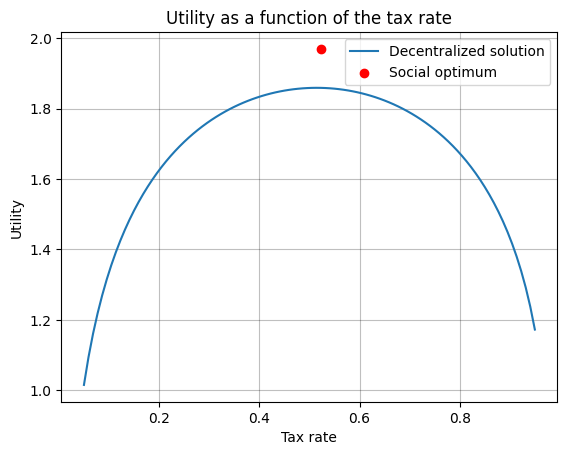

In [18]:

fig = plt.figure()

bx = fig.add_subplot(1,1,1)
bx.plot(tau_vec,u_tau, label ='Decentralized solution')
bx.set_title('Utility as a function of the tax rate')
bx.set_xlabel('Tax rate')
bx.scatter(Tau_optimal_Q4, Utility_Optimal_Q4, color='red', label = 'Social optimum')
bx.set_ylabel('Utility')

bx.legend()

plt.show()

We are seeing a higher utility than possible in question 1.1-1.3. The reason relates to the externality that government spending has on utility. We are therefore internalizing the externality by using a social planner.

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Problem:** Given $\tau$ find the G which secures that the government constraint holds. 

**Inputs:** $\tau$ from exercise 4 and the other parameters. 

**Outputs:** The government consumption (G) which clears the market. From this we can also output working hours. 

**Algorithm:** `find_government_consumption()`

1. Define utility functions and maximized it for given G. 
2. Based on the clearing function find the clearing value (government consumption subtracted tax income)
3. Find the root of this function (I.e. government consumption is equal to tax income)
4. Save the values for this case. Otherwise it will not return anything. 



**1.5.1** Case 1

In [96]:
#We refer to the pyfile for documentation.
opt_Q5_case1=Q1.Question_1_5(sigma=1.001,rho=1.001)
opt_Q5_case1.find_government_consumption()


 sigma = 1.001. rho = 1.001  G = 7.823717 -> clearing = -0.00.Working hours = 14.97


**1.5.2** Case 2

In [97]:
opt_Q5_case2=Q1.Question_1_5(sigma=1.5,rho=1.5)
opt_Q5_case2.find_government_consumption()

 sigma = 1.500. rho = 1.500  G = 5.035706 -> clearing = -0.00.Working hours = 9.64


We see that higher $\sigma$ and $\rho$ leads to fewer working hours. For $\rho$ it makes intuitively sense as the discounting of consumption is higher and therefore the consumer will work less, as the disutility have not changed. 

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Problem:** Find the socially optimal tax rate, which maximizes worker utility. 

**Inputs:** The other parameters. 

**Outputs:** Optimal working hours, optimal tax rate and utility for the optimal case.  

**Algorithm:** `solve_social_optimum_Q6()`

1. Define utility functions and maximized it for $\tau$ and G given the bounds and constraints. 
2. Save the results. 

**1.6.1** Case 1

In [109]:
opt_Q6_case1=Q1.Question_1_6(sigma=1.001,rho=1.001)
opt_Q6_case1.solve_social_optimum_Q6()

 Optimal labor supply = 22.11. Optimal tax rate = 0.52. Utility in optimum = 1.97.


**1.6.2**:

In [107]:
opt_Q6_case2=Q1.Question_1_6(sigma=1.5,rho=1.5)
opt_Q6_case2.solve_social_optimum_Q6()

 Optimal labor supply = 13.35. Optimal tax rate = 0.54. Utility in optimum = 1.08.


For case 1 we expected to see a similar case as in exercise 1.4, which is exactly what we can see. This indicates that our model is correct. For case 2 we expected to see a smaller working effort for the same reason as in exercise 1.5. 

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

**2.1.1** Defining parameters

In [8]:
# Defining symbols
l_q2 = sm.symbols('l')
eta_q2 = sm.symbols('eta')
kappa_q2 = sm.symbols('kappa')
w_q2 = sm.symbols('w')


# write out the profit function
profit = kappa_q2*l_q2**(1-eta_q2)-w_q2*l_q2
profit



kappa*l**(1 - eta) - l*w

**2.1.2** Differentiate wrt. for l and solve for l. 

In [9]:
#Differentiate
foc_hair=sm.Eq(sm.diff(profit, l_q2),0)

#Solve for l
l_optimal = sm.solve(foc_hair, l_q2)[0]
l_optimal

(kappa*(1 - eta)/w)**(1/eta)

**2.1.3** Finding the values

In [10]:
l_optimal_function= sm.lambdify(args=(kappa_q2,eta_q2,w_q2),expr=l_optimal)

#For the values
print(f' Optimal value for kappa equal to 1.00: {l_optimal_function(1,0.5,1):.2f}')
print(f' Optimal value for kappa equal to 2.00: {l_optimal_function(2,0.5,1):.2f}')


 Optimal value for kappa equal to 1.00: 0.25
 Optimal value for kappa equal to 2.00: 1.00


We hereby have shown analytically that we get the right solve. We can also define the function and minimize it. 

**2.1.4** Numerical solution

In [11]:
#Defining the profit function (Negative value of it since we are minimizing)
def profitfunction(l,kappa,eta=0.5,w=1): 
    return -kappa*l**(1-eta)+w*l

#Profit maximazation
def profit_max(kappa): 
    result = optimize.minimize_scalar(lambda l: profitfunction(l,kappa))
    print(f' Optimal value for kappa equal to {kappa:.2f}: {result.x:.2f}')

#Different values of kappa. 
for kappa in [1.0,2.0]: 
    profit_max(kappa)

 Optimal value for kappa equal to 1.00: 0.25
 Optimal value for kappa equal to 2.00: 1.00


Hereby we get the same results. And we have found the optimal working hours for one period. 

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

**2.2.1** Baseline parameters and distribution for epsilon

In [12]:
#Defining parameters
rho_Q2=0.9
iota_Q2=0.01
sigma_Q2=0.1
R_Q2=(1+0.01)**(1/12)
t=119

#Epsilon
epsilon_Q2_mean=-0.5*(sigma_Q2**2)
epsilon_Q2_std=sigma_Q2
epsilon_Q2_var=epsilon_Q2_std**2

**2.2.2** Rewriting for AR

By taking the exponential function we can rewrite the expression for kappa. This is important as we have an expected value for the log in period t, which will be negative due to the negative shock. 
$$
log(\kappa_t)=\rho*log(\kappa_{t-1})+\epsilon_t \leftrightarrow \kappa_t=\kappa_{t-1}^\rho*e^{\epsilon_t}
$$

**2.2.3** Defining profit function

In [18]:
#Profit function: 
def profit_function_Q2(kappa,labor,t,adj,w=1,eta=0.5,R=R_Q2): 
    return (kappa*labor**(1-eta)-w*labor-adj)/(R**t)    


**2.2.4** Looping to find H

The overall idea is to for every period: 

1. Calcuate $\kappa_t$
2. Based on this l_t can be calculated
3. The adjustment costs can be calculated
4. Then profit can be calculated
5. Save the values for the next period

Lastly, summing over the profit vec. 

In [56]:
#Defining vector for profit
kappa_vec = np.zeros((t,1))
labor_vec = np.zeros((t,1))
profit_vec = np.zeros((t,1))


for i in range(t): 
    if i == 0.0:
        #Step 1
        kappa_i=1**(rho_Q2)*np.exp(epsilon_Q2_mean)
        kappa_vec[i]=kappa_i
        #Step 2
        labor_i=l_optimal_function(kappa_i,eta=0.5,w=1)
        labor_vec[i]=labor_i
        labor_previous=0
        #Step 3
        if labor_previous != labor_i:
            adj_value = -0.01
        else:
            adj_value = 0
        
        #Step 4 Calculating the new profit
        profit_vec[i]=profit_i=profit_function_Q2(kappa_i,labor_i,t,adj_value)
        #Step 5- Defining value for next loop
        kappa_previous=kappa_i
        labor_previous=labor_i
    else: 
        #Step 1
        kappa_i = kappa_previous**(rho_Q2)*np.exp(epsilon_Q2_mean)
        kappa_vec[i]=kappa_i
        #Step 2
        labor_i=l_optimal_function(kappa_i,eta=0.5,w=1)
        labor_vec[i]=labor_i
        #Step 3
        if labor_previous != labor_i:
            adj_value = -0.01
        else:
            adj_value = 0
        #Step 4
        profit_vec[i]=profit_i=profit_function_Q2(kappa_i,labor_i,t,adj_value)

        #Step 5 - Defining value for next period
        kappa_previous=kappa_i
        labor_previous=labor_i

**2.2.5** Summing the vector

In [61]:
#Now we can find the H functions, i.e. the expected value of the profit, where we have that epsilon is expected equal to a half. We use numpy to get it is a number. 
profit_sum=np.sum(profit_vec)
print(f' Theoretical value of the sum is: {profit_sum:.2f}')

 Theoretical value of the sum is: 25.66


**2.2.6** Find the empirical value, i.e. the approximated value. The overall idea is the same as in 2.2.4. However, now the epsilons will be random and we repeat the loop multiple times. 


In [58]:
#Defining number of iterations
K=1000
np.random.seed(1964)

#Profit vector for each iteration
profit_vec_K=np.zeros((K,1))
profit_vec_i=np.zeros((t,1))
#Normal distribution

for j in range(K):
    epsilon = np.random.normal(epsilon_Q2_mean, epsilon_Q2_var, size=119)
    for i in range(t): 
        if i == 0.0:
            #Step 1
            kappa_i=1**(rho_Q2)*np.exp(epsilon[i])
            kappa_vec[i]=kappa_i
            #Step 2
            labor_i=l_optimal_function(kappa_i,eta=0.5,w=1)
            labor_vec[i]=labor_i
            labor_previous=0
            #Step 3
            if labor_previous != labor_i:
                adj_value = -0.01
            else:
                adj_value = 0
            
            #Step 4 Calculating the new profit
            profit_vec_i[i]=profit_i=profit_function_Q2(kappa_i,labor_i,t,adj_value)
            #Step 5- Defining value for next loop
            kappa_previous=kappa_i
            labor_previous=labor_i
        else: 
            #Step 1
            kappa_i = kappa_previous**(rho_Q2)*np.exp(epsilon[i])
            kappa_vec[i]=kappa_i
            #Step 2
            labor_i=l_optimal_function(kappa_i,eta=0.5,w=1)
            labor_vec[i]=labor_i
            #Step 3
            if labor_previous != labor_i:
                adj_value = -0.01
            else:
                adj_value = 0
            #Step 4
            profit_vec_i[i]=profit_i=profit_function_Q2(kappa_i,labor_i,t,adj_value)

            #Step 5 - Defining value for next period
            kappa_previous=kappa_i
            labor_previous=labor_i
    profit_vec_K[j]=np.sum(profit_vec_i)


In [59]:
#Finding empirical value
profit_vec_K_final=np.sum(profit_vec_K)/K
print(f' Empirical value of the sum is: {profit_vec_K_final:.2f}')

 Empirical value of the sum is: 25.70


We have that the empirical value is 25.70, i.e. deviations on 0.04. This is the case 1000 iterations, while we are not getting that much closer with 10.000. Therefore, we use 1000 iterations. 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [23]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [24]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [25]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [155]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

**3.1.1**: Making the loop

In [217]:


#Step 1
bound_low=-600
bound_high=600
bounds=[(bound_low,bound_high),(bound_low,bound_high)]
tau=10e-8

#Step 2
K = 1000
K_lower_bar = 10

#Important to take the seed BEFORE looping. Otherwise, no convergence. 
np.random.seed(1964)

#Intermezzo - Making a vector for the initial guess
initial_guesses = []


#Step 3
for i in np.linspace(0,K-1,K): 
    #Step 3.A
    xk = [np.random.uniform(bound_low,bound_high), np.random.uniform(bound_low,bound_high)]

    #Step 3.B
    if i < K_lower_bar: 
        #Optimizer by first setting initial guess
        xk0 = xk
        result = optimize.minimize(griewank,xk0,method='BFGS',tol=tau)

        #Getting the x values
        xkstar = result.x

        #Calculating function value
        fkstar = result.fun

        #Step 3.F
        if i == 0 or fkstar<fstar:
            xstar=xkstar
            fstar=griewank(xstar)
            print(f' Round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')

        #Step 3.G
        if fstar<tau: 
            print(f' Stopped in round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
            break
    
    else: 
        #Step 3.C
        psi_k=0.5*2/(1+np.exp((i-K_lower_bar)/100))
        #Step 3.D We need to make an array to multiply. 
        xk = np.array(xk)
        xstar = np.array(xstar)
        xk0=psi_k*xk+(1-psi_k)*xstar
        #Step 3.E
        result = optimize.minimize(griewank,xk0,method='BFGS',tol=tau)

        #Getting the x values
        xkstar = result.x

        #Calculating function value
        fkstar = result.fun

        #Step 3.F
        if fkstar<fstar:
            xstar=xkstar
            fstar=griewank(xstar)
            print(f' Round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
        #Step 3.G
        if fstar<tau: 
            print(f' Stopped in round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
            break
    #Saving initial guesses
    initial_guesses.append(xk0)



 Round: 0.00: X_1-value: 452.15, X_2-value: 479.33. Function value: 108.64
 Round: 1.00: X_1-value: -292.01, X_2-value: -457.15. Function value: 73.63
 Round: 2.00: X_1-value: -53.38, X_2-value: -39.95. Function value: 1.11
 Round: 33.00: X_1-value: 3.14, X_2-value: 22.19. Function value: 0.13
 Round: 95.00: X_1-value: 18.84, X_2-value: 8.88. Function value: 0.11
 Round: 119.00: X_1-value: 9.42, X_2-value: 4.44. Function value: 0.03
 Round: 254.00: X_1-value: 3.14, X_2-value: 4.44. Function value: 0.01
 Round: 287.00: X_1-value: 3.14, X_2-value: 4.44. Function value: 0.01
 Round: 294.00: X_1-value: -0.00, X_2-value: -0.00. Function value: 0.00
 Stopped in round: 294.00: X_1-value: -0.00, X_2-value: -0.00. Function value: 0.00


**3.1.2** Plotting

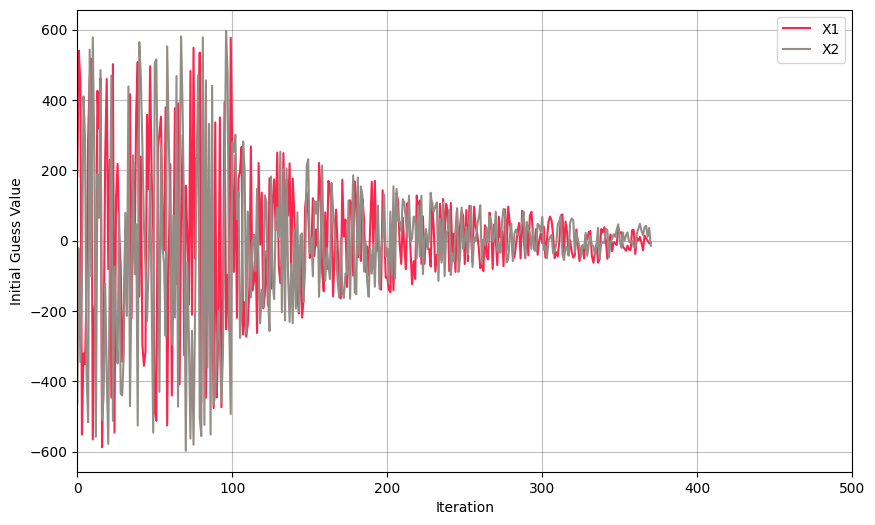

In [245]:
#Making the initial guess into an array in order to plot. 
initial_guesses_array = np.array(initial_guesses)

# Plot
plt.figure(figsize=(10, 6))
#Taking the first row of the array, i.e. X1
plt.plot(initial_guesses_array[:, 0], color=(251/255,38/255,78/255), label='X1')
#Taking the first row of the array, i.e. X2
plt.plot(initial_guesses_array[:, 1], color=(148/255,141/255,134/255), label='X2')
#Labels. 
plt.xlabel('Iteration')
plt.ylabel('Initial Guess Value')
plt.legend()

plt.xlim([0, 500])
plt.show()

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

**3.2.1** Running again 

In [239]:
#Step 1
bound_low=-600
bound_high=600
bounds=[(bound_low,bound_high),(bound_low,bound_high)]
tau=10e-8

#Step 2
K = 1000
K_lower_bar_Q2 = 100

#Important to take the seed BEFORE looping. Otherwise, no convergence. 
np.random.seed(1964)

#Intermezzo - Making a vector for the initial guess
initial_guesses_Q2 = []


#Step 3
for i in np.linspace(0,K-1,K): 
    #Step 3.A
    xk = [np.random.uniform(bound_low,bound_high), np.random.uniform(bound_low,bound_high)]

    #Step 3.B
    if i < K_lower_bar_Q2: 
        #Optimizer by first setting initial guess
        xk0 = xk
        result = optimize.minimize(griewank,xk0,method='BFGS',tol=tau)

        #Getting the x values
        xkstar = result.x

        #Calculating function value
        fkstar = result.fun

        #Step 3.F
        if i == 0 or fkstar<fstar:
            xstar=xkstar
            fstar=griewank(xstar)
            print(f' Round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')

        #Step 3.G
        if fstar<tau: 
            print(f' Stopped in round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
            break
    
    else: 
        #Step 3.C
        psi_k=0.5*2/(1+np.exp((i-K_lower_bar_Q2)/100))
        #Step 3.D We need to make an array to multiply. 
        xk = np.array(xk)
        xstar = np.array(xstar)
        xk0=psi_k*xk+(1-psi_k)*xstar
        #Step 3.E
        result = optimize.minimize(griewank,xk0,method='BFGS',tol=tau)

        #Getting the x values
        xkstar = result.x

        #Calculating function value
        fkstar = result.fun

        #Step 3.F
        if fkstar<fstar:
            xstar=xkstar
            fstar=griewank(xstar)
            print(f' Round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
        #Step 3.G
        if fstar<tau: 
            print(f' Stopped in round: {i:.2f}: X_1-value: {xstar[0]:.2f}, X_2-value: {xstar[1]:.2f}. Function value: {fstar:.2f}')
            break
    #Saving initial guesses
    initial_guesses_Q2.append(xk0)

 Round: 0.00: X_1-value: 452.15, X_2-value: 479.33. Function value: 108.64
 Round: 1.00: X_1-value: -292.01, X_2-value: -457.15. Function value: 73.63
 Round: 2.00: X_1-value: -53.38, X_2-value: -39.95. Function value: 1.11
 Round: 95.00: X_1-value: 50.24, X_2-value: -17.75. Function value: 0.71
 Round: 112.00: X_1-value: 18.84, X_2-value: 35.51. Function value: 0.40
 Round: 119.00: X_1-value: 3.14, X_2-value: 22.19. Function value: 0.13
 Round: 213.00: X_1-value: 18.84, X_2-value: 8.88. Function value: 0.11
 Round: 254.00: X_1-value: -6.28, X_2-value: 8.88. Function value: 0.03
 Round: 294.00: X_1-value: -6.28, X_2-value: -0.00. Function value: 0.01
 Round: 330.00: X_1-value: -3.14, X_2-value: 4.44. Function value: 0.01
 Round: 351.00: X_1-value: 3.14, X_2-value: 4.44. Function value: 0.01
 Round: 446.00: X_1-value: -3.14, X_2-value: 4.44. Function value: 0.01
 Round: 486.00: X_1-value: -0.00, X_2-value: -0.00. Function value: 0.00
 Stopped in round: 486.00: X_1-value: -0.00, X_2-valu

**3.2.2** Plotting

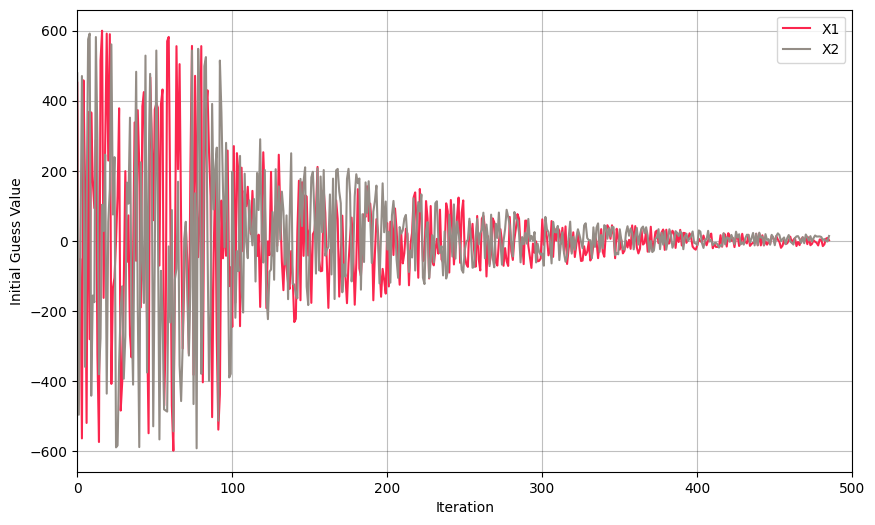

In [244]:
#Making the initial guess into an array in order to plot. 
initial_guesses_array_Q2 = np.array(initial_guesses_Q2)

# Plot
plt.figure(figsize=(10, 6))
#Taking the first row of the array, i.e. X1
plt.plot(initial_guesses_array_Q2[:, 0],color=(251/255,38/255,78/255), label='X1')
#Taking the first row of the array, i.e. X2
plt.plot(initial_guesses_array_Q2[:, 1], color=(148/255,141/255,134/255), label='X2')
#Labels. 
plt.xlabel('Iteration')
plt.ylabel('Initial Guess Value')
plt.legend()

plt.xlim([0, 500])
plt.show()

The convergence is slower in the second case. However, there is a trade-off with value of K_lower_bar. For a high K_lower_bar we will have a higher chance of being close to the solution in the beginning. This should give fewer iterations. However, there will also been made more iterations, which will make it slower. Further, with a higher K_lower_bar there will also be made more "random" guesses, while passing K_lower_bar does that we will have initial values based on the previous optimal value. This can give a faster convergence. 

With our seed 40 iterations will give convergence in only 119 steps illustrating the trade-off. 

It should be noted that the optimal value of K_lower_bar also depends on the seed. But, the pro and cons discussed above are general. 